### Alternative calculation of WMT
Based on approach during phd  
All surface based, no inclusion of sw penetration or b factor
This is to check why I am getting an order of magnitude error in my other calculation

In [2]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
%matplotlib inline

In [109]:
rootdir = '/local/projects/so_decadal_variability/'
grid_name = 'en4'
ocean_name = 'en4'
flux_name = 'erai'
ocean_times = '197901-201812'
flux_times = '1979-2018'
time_bnds = [0,120]
# Grid
garea = xr.open_dataset(rootdir+'grid/SO_grid_garea_'+grid_name+'.nc')
dA = garea.cell_area
# Hydrography
ct = xr.open_dataset(rootdir+'ocean/SO_ocean_ct_'+ocean_name+'_'+ocean_times+'.nc').isel(depth=0,time=slice(time_bnds[0],time_bnds[1]))
sa = xr.open_dataset(rootdir+'ocean/SO_ocean_sa_'+ocean_name+'_'+ocean_times+'.nc').isel(depth=0,time=slice(time_bnds[0],time_bnds[1]))
sigma0 = xr.open_dataset(rootdir+'ocean/SO_ocean_sigma0_'+ocean_name+'_'+ocean_times+'.nc').isel(depth=0,time=slice(time_bnds[0],time_bnds[1]))
alpha = xr.open_dataset(rootdir+'ocean/SO_ocean_alpha_'+ocean_name+'_'+ocean_times+'.nc').isel(depth=0,time=slice(time_bnds[0],time_bnds[1]))
beta = xr.open_dataset(rootdir+'ocean/SO_ocean_beta_'+ocean_name+'_'+ocean_times+'.nc').isel(depth=0,time=slice(time_bnds[0],time_bnds[1]))
rho = xr.open_dataset(rootdir+'ocean/SO_ocean_rho_'+ocean_name+'_'+ocean_times+'.nc').isel(depth=0,time=slice(time_bnds[0],time_bnds[1]))
# Merge
ocean = xr.merge([ct,sa,sigma0,alpha,beta,rho])
# Heat and freshwater flux
Q = -xr.open_dataset(rootdir+'flux/SO_flux_ht_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=ct.time)
Qsw = -xr.open_dataset(rootdir+'flux/SO_flux_sr_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=ct.time)
FW = xr.open_dataset(rootdir+'flux/SO_flux_fw_'+flux_name+'_'+grid_name+'_'+flux_times+'.nc').isel(time=slice(time_bnds[0],time_bnds[1])).assign_coords(time=ct.time)

In [127]:
# Calculate the density flux
Cp = 4200
D_t = -(ocean.alpha/Cp)*(Q.ht+Qsw.sr)
D_s = ocean.beta*ocean.sa*FW.fw
D_in = D_t + D_s

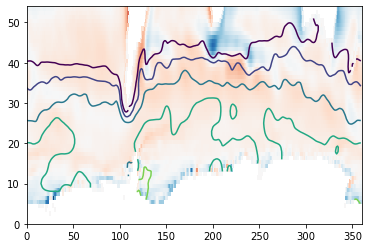

In [133]:
plt.pcolormesh(D_in.mean('time'),vmin=-1E-5,vmax=1E-5,cmap='RdBu_r')
plt.contour(ocean.sigma0.mean('time'),levels=srange[0::4])

In [131]:
# Calculate water mass transformation
srange = xr.DataArray(np.linspace(26,28,21),dims=['srange'],coords=[srange])
D = xr.DataArray(np.zeros(shape=(srange.size,D_in.time.size)),dims=['srange','time'],coords=[srange,D_in.time])
i=0
for s in srange:
    D[i,:] = (D_in*dA).where(ocean.sigma0>s).sum(['lon','lat'])
    i+=1
F = D.diff('srange')/srange.diff('srange')

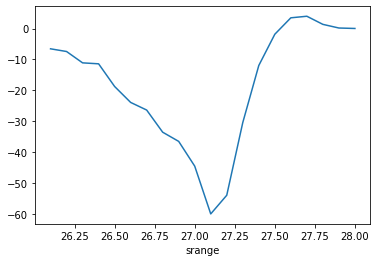

In [132]:
(F*1E-6).mean('time').plot()

<xarray.DataArray (srange: 20)>
array([26. , 26.1, 26.2, 26.3, 26.4, 26.5, 26.6, 26.7, 26.8, 26.9, 27. ,
       27.1, 27.2, 27.3, 27.4, 27.5, 27.6, 27.7, 27.8, 27.9])
Coordinates:
  * srange   (srange) float64 26.0 26.1 26.2 26.3 26.4 ... 27.6 27.7 27.8 27.9